In [224]:
import pandas as pd
import numpy as np
import collections

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [225]:
DIM = 2
NUM_CLASSES = 4

In [226]:
# Generate mu and covariance:
list_mu = list()
list_cov = list()
scale = [2, 6, 10, 14]
for i in range(NUM_CLASSES):
  scale_mu = np.random.randint(1, 4)
  mu = np.random.rand(1,2) * scale_mu + scale[i]

  scale_var = np.random.randint(1, 3)
  A = np.random.rand(2,2) + scale_var * np.eye(2,2)
  cov = A.dot(A.T)
  list_mu.append(mu)
  list_cov.append(cov)

In [227]:
print(list_mu)

[array([[3.50642088, 2.78109719]]), array([[6.32469298, 6.67614539]]), array([[10.90825425, 10.74935667]]), array([[15.6206049 , 15.33560271]])]


In [228]:
data = list()
for i in range(NUM_CLASSES):
  data_class = list()
  num_sample = np.random.randint(2000, 2500)
  for j in range(num_sample):
    sample = np.random.multivariate_normal(np.reshape(list_mu[i], (-1,)), list_cov[i])
    data_class.append(sample)
  data_class = np.array(data_class)
  data.append(data_class)
data = np.array(data)

<ipython-input-228-949be84f8c67>:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array(data)


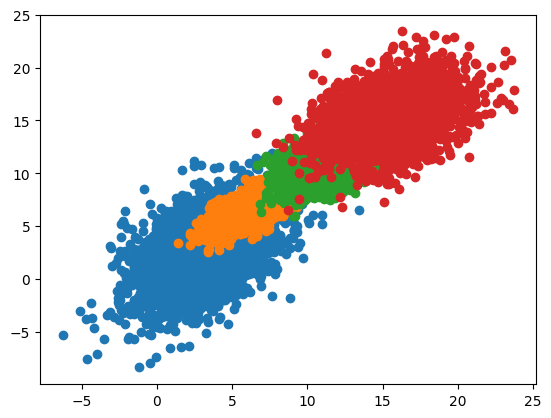

In [229]:
list_color = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
for i in range(NUM_CLASSES):
  plt.scatter(data[i][:,0], data[i][:,1], c=list_color[i])

In [230]:
X = np.vstack(data)

In [231]:
np.random.shuffle(X)

In [232]:
def min_max_scaling(x, output):
  if output != True:
    max_val = np.amax(x, axis=0)
    min_val = np.amin(x, axis=0)
    x = (x - min_val) / (max_val - min_val)
  else:
    x = x - np.amin(x, axis=0)
  return x

x_normalized = min_max_scaling(X, output=False)

In [233]:
class MixturesofGaussians():

  def __init__(self, x_train, y_train=None, num_classes=None):
    self.pi = None
    self.mu = None
    self.sigma = None
    self.x_train = x_train
    self.y_train = y_train
    self.classes = None
    self.num_classes = None if num_classes == None else num_classes
    self.instances = None
    self.features = None
    self.data = None

    self.initialize_parameters(heuristic=True)
  
  def initialize_parameters(self, heuristic):

    self.num_instances = np.shape(self.x_train)[0]
    self.num_features = np.shape(self.x_train)[1]

    if heuristic == "True":

      # initialize pi
      self.classes, counts = np.unique(self.y_train, return_counts=True)
      self.num_classes = len(self.classes)

      self.pi = np.reshape(counts / self.num_instances, (-1,1))

      # initialize mu and sigma
      self.data = np.hstack([self.x_train, np.reshape(self.y_train, (-1,1))])
      self.sigma = np.zeros((self.num_classes, self.num_features, self.num_features))
      self.mu = np.zeros((self.num_classes, self.num_features))
      for i in range(self.num_classes):
        if np.linalg.det(np.cov(self.data[self.data[:,-1]==i][:,:-1].T, ddof=1)) > 1e-15:
          self.mu[i,:] = np.average(self.data[self.data[:,-1]==i][:,:-1],axis=0)
          self.sigma[i,:] = np.cov(self.data[self.data[:,-1]==i][:,:-1].T, ddof=1)

        else:
          self.mu[i,:] = np.average(self.x_train,axis=0)
          self.sigma[i:,] = np.eye(self.num_features, self.num_features)
    else:
      self.sigma = np.zeros((self.num_classes, self.num_features, self.num_features))
      self.mu = np.zeros((self.num_classes, self.num_features))

      self.pi = np.array([1/self.num_classes for i in range(self.num_classes)])
      self.mu = np.random.rand(self.num_classes, self.num_features)
      for i in range(self.num_classes):
        A = np.random.rand(self.num_features, self.num_features)
        self.sigma[i,:] = A.dot(A.T)

  def learning(self, epoch=30, parallel=True, print_loss=True):
    # E step
    p_z_given_x = np.zeros((self.num_instances, self.num_classes))
    w = np.zeros((self.num_instances, self.num_classes))
    pi = np.copy(self.pi)
    mu = np.copy(self.mu)
    sigma = np.copy(self.sigma)

    it = 0
    old_loss = 1e-18
    while it < epoch:
      it += 1

      if parallel == True:
      # E step
        list_det = np.linalg.det(self.sigma)
        for j in range(self.num_classes):
          sigma_inv = np.linalg.inv(self.sigma[j,:])
          sigma_det = list_det[j]
          c = 1. / ((2. * np.pi) ** (self.num_features / 2) * np.sqrt(sigma_det))
          x_mu = self.x_train - self.mu[j,:]
          p_z_given_x[:,j] = c * np.exp((-0.5) * np.diag(x_mu.dot(sigma_inv).dot(x_mu.T))) * self.pi[j]

        p_z_given_x = p_z_given_x / np.reshape(np.sum(p_z_given_x, axis=1), (-1,1))
        # M step
        self.pi = np.reshape((1/self.num_instances) * np.sum(p_z_given_x, axis=0), (-1,1))
        for j in range(self.num_classes):
          self.mu[j,:] = np.sum(np.reshape(p_z_given_x[:,j], (-1,1)) * self.x_train, axis=0) / np.sum(p_z_given_x[:,j],axis=0)
          x_mu = self.x_train - self.mu[j,:]
          self.sigma[j,:] = (np.reshape(p_z_given_x[:,j], (-1,1)) * x_mu).T.dot(x_mu) / np.sum(p_z_given_x[:,j],axis=0)

      else:
        n = self.num_instances
        d = self.num_features
        k = self.num_classes

        def p_x_given_z(x, mu, sigma):
          c = 1. / ((2. * np.pi) ** (d / 2) * np.sqrt(np.linalg.det(sigma)))
          x_minus_mu = x - mu
          sigma_inv = np.linalg.inv(sigma)
          p_val = c * np.exp(-.5 * x_minus_mu.dot(sigma_inv).dot(x_minus_mu.T))
          return p_val

        for i in range(n):
            for j in range(k):
                w[i, j] = p_x_given_z(self.x_train[i], mu[j], sigma[j]) * pi[j]
        w /= np.sum(w, axis=1, keepdims=True)

        pi = np.reshape(np.mean(w, axis=0), (-1,1))
        for j in range(k):
            w_j = w[:, j:j+1]
            mu[j] = np.sum(w_j * self.x_train, axis=0) / np.sum(w_j)
            sigma[j] = np.zeros_like(sigma[j])
            for i in range(n):
                x_minus_mu = self.x_train[i] - mu[j]
                sigma[j] += w[i, j] * np.outer(x_minus_mu, x_minus_mu)
            sigma[j] /= np.sum(w_j)
        self.sigma = np.copy(sigma)
        self.mu = np.copy(mu)
        self.pi = np.copy(pi)

      loss = self.log_likelihood()


      if print_loss == True:
        print(f"In epoch {it}, log likelihood value: {self.log_likelihood()}, larger than old log likelihood: {loss > old_loss}")
        old_loss = loss


  def log_likelihood(self):
    loss = 0
    list_det = np.linalg.det(self.sigma)
    for i in range(self.num_instances):
      m1 = (self.x_train[i] - self.mu).dot(np.linalg.inv(self.sigma))
      m2 = np.reshape(self.x_train[i] - self.mu, (self.num_classes, self.num_features, 1))
      m3 = np.diag(np.reshape(np.einsum('lij,ljk->lik', m1, m2), (self.num_classes, self.num_classes)))
      p_x_given_z = np.reshape(((2*np.pi)**((-0.5)*self.num_features)) * (list_det ** (-0.5)) * np.exp((-0.5)*m3), (self.num_classes, 1))
      loss += np.log(p_x_given_z.T.dot(self.pi))
    return loss / self.num_instances

  def log_likelihood_2(self):
    x = self.x_train
    mu = self.mu
    sigma = self.sigma
    phi = self.pi
    num_examples = self.num_instances
    dim = self.num_features
    num_clusters = self.num_classes
    ll = 0
    for i in range(num_examples):
        ll1 = 0
        for j in range(num_clusters):
            p = (1/(((2 * np.pi)**(dim/2))* np.sqrt(np.linalg.det(sigma[j])))) * np.exp(-0.5 * np.transpose(np.reshape(x[i], (-1,1)) - np.reshape(mu[j], (-1,1))) .dot(np.linalg.inv(sigma[j])).dot(np.reshape(x[i], (-1,1)) - np.reshape(mu[j], (-1,1)))) * phi[j]
            ll1 += p
        ll += np.log(ll1)
    return ll / self.num_instances

  def predict(self, x_test):
    test_instances = x_test.shape[0]
    p_z_given_x = np.zeros((test_instances, self.num_classes))
    list_det = np.linalg.det(self.sigma)
    for j in range(self.num_classes):
      sigma_inv = np.linalg.inv(self.sigma[j,:])
      sigma_det = list_det[j]
      c = 1. / ((2. * np.pi) ** (self.num_features / 2) * np.sqrt(sigma_det))
      x_mu = x_test - self.mu[j,:]
      p_z_given_x[:,j] = c * np.exp((-0.5) * np.diag(x_mu.dot(sigma_inv).dot(x_mu.T))) * self.pi[j]

    p_z_given_x = p_z_given_x / np.reshape(np.sum(p_z_given_x, axis=1), (-1,1))
    return np.argmax(p_z_given_x, axis=1)

In [234]:
model = MixturesofGaussians(x_train=x_normalized, num_classes=4)

In [235]:
model.learning(epoch=100, parallel=True)

In epoch 1, log likelihood value: [[1.63133086]], larger than old log likelihood: [[ True]]
In epoch 2, log likelihood value: [[1.63997149]], larger than old log likelihood: [[ True]]
In epoch 3, log likelihood value: [[1.64376353]], larger than old log likelihood: [[ True]]
In epoch 4, log likelihood value: [[1.64871295]], larger than old log likelihood: [[ True]]
In epoch 5, log likelihood value: [[1.65555999]], larger than old log likelihood: [[ True]]
In epoch 6, log likelihood value: [[1.66350817]], larger than old log likelihood: [[ True]]
In epoch 7, log likelihood value: [[1.67075776]], larger than old log likelihood: [[ True]]
In epoch 8, log likelihood value: [[1.67626724]], larger than old log likelihood: [[ True]]
In epoch 9, log likelihood value: [[1.68019139]], larger than old log likelihood: [[ True]]
In epoch 10, log likelihood value: [[1.68305218]], larger than old log likelihood: [[ True]]
In epoch 11, log likelihood value: [[1.68521812]], larger than old log likeliho

In [239]:
sample = x_normalized[:1000]

In [240]:
res = model.predict(sample)

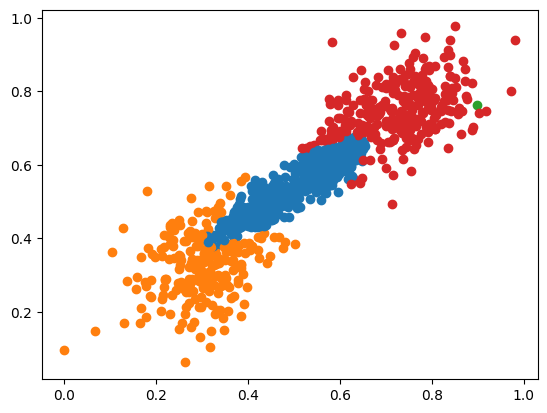

In [241]:
for i in range(len(sample)):
  plt.scatter(sample[i,0], sample[i,1], c=list_color[res[i]])